In this project we are going to be recreating the google machine learning crash course project on introduction to Neural Nets. This Colab builds a deep neural network to perform more sophisticated linear regression than the earlier Colabs.

**DATASET**

We are going to be using the California Housing Dataset.

In [1]:
# importing relevant models
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading our dataset
train_df = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv')
test_df = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv')

#suffling our training data
train_df = train_df.sample(frac=1)
display(train_df.head())
print(f'Train data shape: {train_df.shape}\nTest data shape: {test_df.shape}')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10370,-120.16,39.01,16.0,1463.0,264.0,54.0,26.0,4.9750,206300.0
1949,-117.30,34.14,39.0,1781.0,335.0,841.0,320.0,1.9432,89000.0
10420,-120.27,38.31,13.0,3297.0,662.0,267.0,97.0,3.0750,108300.0
4220,-118.00,34.15,48.0,3436.0,673.0,1540.0,648.0,4.2750,256800.0
12941,-121.84,37.98,8.0,7505.0,1089.0,3325.0,1016.0,5.2699,204200.0


Train data shape: (17000, 9)
Test data shape: (3000, 9)


In [3]:
# normalizing our data using z score
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean) / train_df_std

test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [4]:
from tensorflow.python.feature_column import feature_column
# creating a feature layer that contains three columns

#create an empty list to store our fearute columns
feature_columns = []

# creating a bucket feature column for latitude
bucket_size = 0.3
latitude_numeric = tf.feature_column.numeric_column('latitude')
latitude_boundaries = list(np.arange(int(min(train_df.latitude)),
                                     int(max(train_df.latitude)),
                                         bucket_size))
latitude = tf.feature_column.bucketized_column(latitude_numeric, latitude_boundaries)

longitude_numeric = tf.feature_column.numeric_column('longitude')
longitude_boundaries = list(np.arange(int(min(train_df.longitude)),
                                      int(max(train_df.longitude)),
                                      bucket_size))
longitude = tf.feature_column.bucketized_column(longitude_numeric, longitude_boundaries)
# crossing features
latitude_x_longitude = tf.feature_column.crossed_column([latitude,longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# represent median income as a float
median_income = tf.feature_column.numeric_column('median_income')
feature_columns.append(median_income)

# represent population as a float
population = tf.feature_column.numeric_column('population')
feature_columns.append(population)

#adding the feature_columns as the input layer
feature_layer = keras.layers.DenseFeatures(feature_columns)

In [5]:
# building a linear regression model as a baseline
lin_model = tf.keras.models.Sequential()
# adding our feature layer as the first layer
lin_model.add(feature_layer)
# adding one layer to our simple linear regression model
lin_model.add(keras.layers.Dense(units=1, input_shape=(1,)))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
loss = "mean_squared_error"
metrics=[tf.keras.metrics.MeanSquaredError()]
lin_model.compile(loss=loss, optimizer=opt, metrics=metrics)

In [6]:
# separate our dependent and independent variables
y_train = np.array(train_df_norm.pop('median_house_value'))
X_train = {name: np.array(value) for name, value in train_df_norm.items()}
y_test = np.array(test_df_norm.pop('median_house_value'))
X_test = {name: np.array(value) for name, value in test_df_norm.items()}

In [7]:
# train our baseline model
history = lin_model.fit(x=X_train, y=y_train, batch_size=1000,epochs=15)

Epoch 1/15


17/17 [==============================] - 1s 3ms/step - loss: 0.6754 - mean_squared_error: 0.6754
Epoch 2/15
17/17 [==============================] - 0s 3ms/step - loss: 0.5708 - mean_squared_error: 0.5708
Epoch 3/15
17/17 [==============================] - 0s 3ms/step - loss: 0.5320 - mean_squared_error: 0.5320
Epoch 4/15
17/17 [==============================] - 0s 4ms/step - loss: 0.5217 - mean_squared_error: 0.5217
Epoch 5/15
17/17 [==============================] - 0s 3ms/step - loss: 0.5209 - mean_squared_error: 0.5209
Epoch 6/15
17/17 [==============================] - 0s 3ms/step - loss: 0.5216 - mean_squared_error: 0.5216
Epoch 7/15
17/17 [==============================] - 0s 4ms/step - loss: 0.5212 - mean_squared_error: 0.5212
Epoch 8/15
17/17 [==============================] - 0s 3ms/step - loss: 0.5211 - mean_squared_error: 0.5211
Epoch 9/15
17/17 [==============================] - 0s 3ms/step - loss: 0.5212 - mean_squared_error: 0.5212
Epoch 10/15
17/17 [====================

In [8]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
metrics = ['mean_squared_error']

In [9]:
# define our plot function
def plot(epochs, hist, metrics):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  for x in metrics:
    plt.plot(epochs, hist[x])
  plt.show()

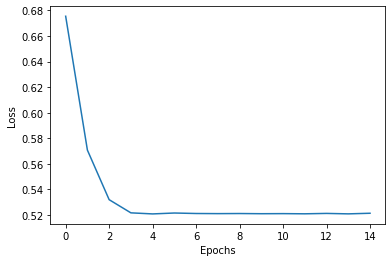

In [10]:
# plotting our loss function 
plot(epochs, hist, metrics)

In [11]:
# evaluate the baseline model
lin_model.evaluate(x=X_test, y=y_test, batch_size=1000)

3/3 [==============================] - 0s 6ms/step - loss: 0.5476 - mean_squared_error: 0.5476


[0.5475926995277405, 0.5475926995277405]

In [16]:
# define our deep neural network model
model = tf.keras.Sequential()
model.add(feature_layer)
# adding our hidden layer
model.add(keras.layers.Dense(units=10,
                             activation='relu',
                             name='hidden1'))
# adding our second hidden layer
model.add(keras.layers.Dense(units=6,
                             activation='relu',
                             name='hidden2'))
# adding the output layer
model.add(keras.layers.Dense(units=1,
                             name='output'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

In [17]:
# train our model
history = model.fit(x=X_train, y=y_train, epochs=20, batch_size=1000)

Epoch 1/20


17/17 [==============================] - 1s 5ms/step - loss: 0.8266 - mean_squared_error: 0.8266
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6410 - mean_squared_error: 0.6410
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5302 - mean_squared_error: 0.5302
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5119 - mean_squared_error: 0.5119
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5094 - mean_squared_error: 0.5094
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5082 - mean_squared_error: 0.5082
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5075 - mean_squared_error: 0.5075
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5074 - mean_squared_error: 0.5074
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5068 - mean_squared_error: 0.5068
Epoch 10/20
17/17 [====================

In [18]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
metrics = ['mean_squared_error']

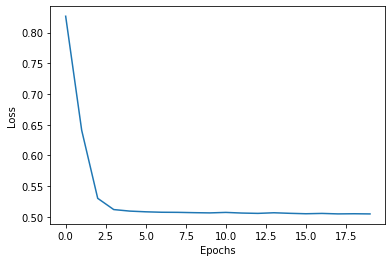

In [19]:
# plotting our loss function 
plot(epochs, hist, metrics)

In [20]:
# evaluate our neural net
model.evaluate(x=X_test, y=y_test, batch_size=1000)

3/3 [==============================] - 0s 5ms/step - loss: 0.5312 - mean_squared_error: 0.5312


[0.5312402844429016, 0.5312402844429016]